<a href="https://colab.research.google.com/github/lcipolina/escher/blob/master/ML/img_quality/koncept512_train_test_py3_with_kuti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install and load libraries

In [1]:
%%capture

# Setup paths
drive_mount = '/content/drive/'
drive_root = drive_mount + 'My Drive/research/data/'  # persistent storage for dataset images
data_root = '/content/koniq/'                         # library install path

!pip install kuti
!git clone https://github.com/subpic/koniq.git
!pip install munch

In [2]:
from kuti import model_helper as mh
from kuti import applications as apps
from kuti import tensor_ops as ops
from kuti import generic as gen
from kuti import image_utils as iu

import pandas as pd, numpy as np, os
from matplotlib import pyplot as plt
from munch import Munch

from google.colab import drive
drive.mount(drive_mount)

Loaded Kuti
Mounted at /content/drive/


### Setup KonIQ-10k dataset images
Download images resized to 512x384 pixels (originals are 1024x768)

In [3]:
%%capture

gen.make_dirs(drive_root+'koniq/')
drive_image_path = drive_root+'koniq/koniq10k_512x384.zip'
if not os.path.exists(drive_image_path):
  !wget -O "$drive_image_path" "http://datasets.vqa.mmsp-kn.de/archives/koniq10k_512x384.zip"

gen.make_dirs(data_root+'images/')
data_images_path = data_root+'images/'
!cp  "$drive_image_path" "$data_images_path"
%cd $data_images_path
!unzip -o koniq10k_512x384.zip
%cd $data_root

### Define the KonCept512 model

In [4]:
from tensorflow.keras.models import Model

ids = pd.read_csv(data_root + 'metadata/koniq10k_distributions_sets.csv')

# Build scoring model
base_model, preprocess_fn = apps.get_model_imagenet(apps.InceptionResNetV2)
head = apps.fc_layers(base_model.output, name='fc', 
                      fc_sizes      = [2048, 1024, 256, 1], 
                      dropout_rates = [0.25, 0.25, 0.5, 0], 
                      batch_norm    = 2)    

model = Model(inputs = base_model.input, outputs = head)

# Parameters of the generator
pre = lambda im: preprocess_fn(
         iu.ImageAugmenter(im, remap=False).fliplr().result)
gen_params = dict(batch_size  = 16,
                  data_path   = data_root+'images/512x384/',
                  process_fn  = pre, 
                  input_shape = (384,512,3),
                  inputs      = ['image_name'],
                  outputs     = ['MOS'])

# Wrapper for the model, helps with training and testing
helper = mh.ModelHelper(model, 'KonCept512', ids, 
                     loss='MSE', metrics=["MAE", ops.plcc_tf],
                     monitor_metric = 'val_loss', 
                     monitor_mode   = 'min', 
                     multiproc   = True, workers = 5,
                     logs_root   = drive_root + 'logs/koniq',
                     models_root = drive_root + 'models/koniq',
                     gen_params  = gen_params)

Loading model InceptionResNetV2
219070464/219055592 [==============================] - 7s 0us/step


### Train it

In [ ]:
# do validation in memory
valid_gen = helper.make_generator(ids[ids.set=='validation'], 
                                  batch_size = 16)

helper.train(valid_gen=valid_gen, lr=1e-4, epochs=40)
helper.load_model()
helper.train(valid_gen=valid_gen, lr=1e-4/5, epochs=20)

Training model: KonCept512/bsz:16 i:1[384,512,3] l:MSE o:1[1]


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
442/442 [==============================] - 350s 701ms/step - loss: 3534.6064 - MAE: 58.2835 - plcc_tf: 0.6617 - val_loss: 3366.3882 - val_MAE: 57.3105 - val_plcc_tf: 0.8100
Epoch 2/40
442/442 [==============================] - 303s 684ms/step - loss: 3352.7605 - MAE: 57.2313 - plcc_tf: 0.8561 - val_loss: 3582.5657 - val_MAE: 59.3504 - val_plcc_tf: 0.8776
Epoch 3/40
442/442 [==============================] - 303s 684ms/step - loss: 3176.0950 - MAE: 55.7074 - plcc_tf: 0.8693 - val_loss: 3027.1306 - val_MAE: 54.4122 - val_plcc_tf: 0.8137
Epoch 4/40
442/442 [==============================] - 303s 685ms/step - loss: 2937.9785 - MAE: 53.4448 - plcc_tf: 0.8509 - val_loss: 2938.4065 - val_MAE: 50.3516 - val_plcc_tf: 0.8170
Epoch 5/40
442/442 [==============================] - 303s 684ms/step - loss: 2598.4607 - MAE: 50.2217 - plcc_tf: 0.8653 - val_loss: 2351.5916 - val_MAE: 47.8475 - val_plcc_tf: 0.8517
Epoch 6/40
442/442 [==============================] - 304s 686ms/step - loss: 21

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
442/442 [==============================] - 338s 712ms/step - loss: 84.6875 - MAE: 7.2830 - plcc_tf: 0.8636 - val_loss: 38.9870 - val_MAE: 4.8753 - val_plcc_tf: 0.9154
Epoch 2/20
442/442 [==============================] - 302s 682ms/step - loss: 87.3420 - MAE: 7.3639 - plcc_tf: 0.8595 - val_loss: 36.2769 - val_MAE: 4.5706 - val_plcc_tf: 0.9104
Epoch 3/20
442/442 [==============================] - 302s 682ms/step - loss: 82.1399 - MAE: 7.1090 - plcc_tf: 0.8715 - val_loss: 68.3541 - val_MAE: 6.5103 - val_plcc_tf: 0.9046
Epoch 4/20
442/442 [==============================] - 307s 693ms/step - loss: 82.6657 - MAE: 7.1615 - plcc_tf: 0.8642 - val_loss: 39.1464 - val_MAE: 4.9120 - val_plcc_tf: 0.9060
Epoch 5/20
442/442 [==============================] - 302s 683ms/step - loss: 79.3572 - MAE: 6.9805 - plcc_tf: 0.8686 - val_loss: 39.0401 - val_MAE: 4.8862 - val_plcc_tf: 0.9132
Epoch 6/20
442/442 [==============================] - 302s 682ms/step - loss: 81.6595 - MAE: 7.0842 - plcc_tf:

### Load trained model

In [5]:
%%capture
# download the pre-trained KonCept512 model
model_root = data_root + 'models/'
gen.make_dirs(model_root)
!wget -O "{model_root}koncep512-model.h5" "http://datasets.vqa.mmsp-kn.de/archives/koncep512-trained-model.h5"
helper.model.load_weights(model_root + 'koncep512-model.h5')

### Test model on the default test set

SRCC: 0.918 | PLCC: 0.932 | MAE: 9.129 | RMSE: 10.241


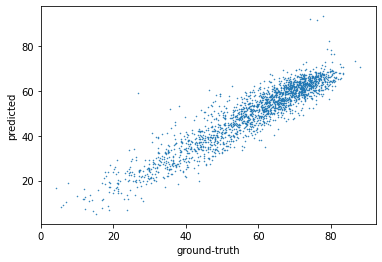

In [ ]:
y_pred = helper.predict()
y_true = ids[ids.set=='test'].MOS.values
apps.rating_metrics(y_true, y_pred);

### Predict on a custom image (example)

In [ ]:
!unzip /content/Upsample_temp.zip -d /content/upsample_temp

In [9]:
from glob import glob

In [10]:
!pwd

/content/koniq


In [78]:
# Returns a list of names in list files - used to iterate
files = glob('/content/upsample_temp/Upsample_temp/temp1/temp1-guidance9/**/*.png', 
                   recursive = True)


In [79]:
# Load an image
#image_path = data_root + 'images/512x384/' + ids.image_name.values[0]
#image_path = '/content/koniq/images/Lu/Lama.png'

lst = []
for file in files:
  im = preprocess_fn(iu.read_image(file))

  # Create a batch, of 1 image
  batch = np.expand_dims(im, 0)

  # Predict quality score
  y_pred = helper.model.predict(batch).squeeze()
  #print(f'Predicted score: {y_pred:.{2}f}, ground-truth score: {ids.MOS.values[0]:.{2}f}')
  #print(f'Predicted score: {y_pred:.{2}f}')
  lst.append(y_pred)

# Print mean of all
scores_raw = np.array(lst)  
print( print(f'Mean: {np.mean(scores_raw)}'))

Mean: 47.53220748901367
None


In [ ]:
image_path

'/content/koniq/images/512x384/10004473376.jpg'